# Use OSMnx to calculate street network indicators

Author: [Geoff Boeing](https://geoffboeing.com/)

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Documentation](https://osmnx.readthedocs.io/en/stable/)
  - [Journal article/citation](http://geoffboeing.com/publications/osmnx-complex-street-networks/)

In [1]:
import matplotlib.cm as cm
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
%matplotlib inline
ox.config(log_console=True)
ox.__version__

'1.0.0'

## Calculate basic street network measures (topological and geometric)

In [2]:
# get the network for Piedmont, calculate its basic stats, then show the average circuity
stats = ox.basic_stats(ox.graph_from_place('Piedmont, California, USA'))
stats['circuity_avg']

1.0909304803297803

To calculate density-based stats, you must also pass the network's bounding area in square meters (otherwise basic_stats() will just skip them in the calculation):

In [3]:
# get the street network for a place, and its area in square meters
place = 'Piedmont, California, USA'
gdf = ox.geocode_to_gdf(place)
area = ox.project_gdf(gdf).unary_union.area
G = ox.graph_from_place(place, network_type='drive_service')

In [4]:
# calculate basic and extended network stats, merge them together, and display
stats = ox.basic_stats(G, area=area)
extended_stats = ox.extended_stats(G, ecc=True, bc=True, cc=True)
for key, value in extended_stats.items():
    stats[key] = value
pd.Series(stats)

n                                                                                    430
m                                                                                   1109
k_avg                                                                            5.15814
intersection_count                                                                   359
streets_per_node_avg                                                             2.79767
streets_per_node_counts                   {0: 0, 1: 71, 2: 2, 3: 305, 4: 48, 5: 3, 6: 1}
streets_per_node_proportion            {0: 0.0, 1: 0.16511627906976745, 2: 0.00465116...
edge_length_total                                                                 120173
edge_length_avg                                                                  108.362
street_length_total                                                              62071.4
street_length_avg                                                                107.763
street_segments_count

Streets/intersection counts and proportions are nested dicts inside the stats dict. To convert these stats to a pandas dataframe (to compare/analyze multiple networks against each other), just unpack these nested dicts first:

In [5]:
# unpack dicts into individiual keys:values
stats = ox.basic_stats(G, area=area)
for k, count in stats['streets_per_node_counts'].items():
    stats['int_{}_count'.format(k)] = count
for k, proportion in stats['streets_per_node_proportion'].items():
    stats['int_{}_prop'.format(k)] = proportion

# delete the no longer needed dict elements
del stats['streets_per_node_counts']
del stats['streets_per_node_proportion']

# load as a pandas dataframe
pd.DataFrame(pd.Series(stats, name='value'))

,value
n,430.000000
m,1109.000000
k_avg,5.158140
intersection_count,359.000000
streets_per_node_avg,2.797674
edge_length_total,120173.167000
edge_length_avg,108.361738
street_length_total,62071.392000
street_length_avg,107.762833
street_segments_count,576.000000


### Inspect betweenness centrality

In [6]:
G_projected = ox.project_graph(G)
max_node, max_bc = max(extended_stats['betweenness_centrality'].items(), key=lambda x: x[1])
max_node, max_bc

(53124805, 0.31262662571073785)

In the city of Piedmont, California, the node with the highest betweenness centrality has ~30% of all shortest paths running through it. Let's highlight it in the plot:

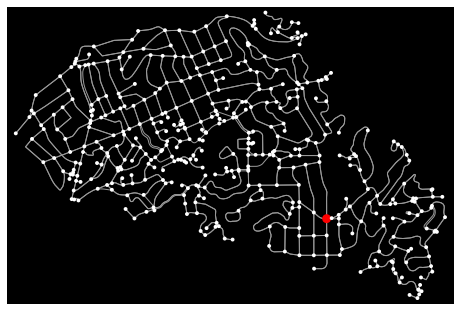

In [7]:
nc = ['r' if node==max_node else 'w' for node in G_projected.nodes()]
ns = [80 if node==max_node else 15 for node in G_projected.nodes()]
fig, ax = ox.plot_graph(G_projected, node_size=ns, node_color=nc, node_zorder=2, bgcolor='k')

~30% of all shortest paths run through the node highlighted in red. Let's look at the relative betweenness centrality of every node in the graph:

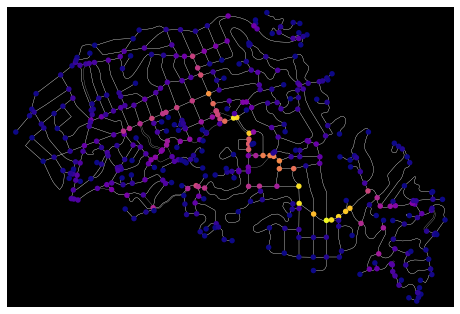

In [8]:
nx.set_node_attributes(G, extended_stats['betweenness_centrality'], 'bc')
nc = ox.plot.get_node_colors_by_attr(G, 'bc', cmap='plasma')
fig, ax = ox.plot_graph(G, node_color=nc, node_size=30, node_zorder=2,
                        edge_linewidth=0.2, edge_color='w', bgcolor='k')

Above, the nodes are visualized by betweenness centrality, from low (dark violet) to high (light yellow). The colors in the colorspace are linearly mapped to the attribute values.